In [24]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

In [25]:
df = yf.download('TSLA', 
                  start='2019-01-01', 
                  end='2024-4-29', 
                  progress=False)
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-22,140.559998,144.440002,138.800003,142.050003,142.050003,107097600
2024-04-23,143.330002,147.259995,141.110001,144.679993,144.679993,124545100
2024-04-24,162.839996,167.970001,157.509995,162.130005,162.130005,181178000
2024-04-25,158.960007,170.880005,158.360001,170.179993,170.179993,126427500
2024-04-26,168.850006,172.119995,166.369995,168.289993,168.289993,109815700


In [26]:
df['Date'] = df.index  # Create a new column 'Date' with the index values
df.reset_index(drop=True, inplace=True) 

In [27]:
close_df = df[['Date', 'Close']]

In [28]:
close_df_copy = close_df.copy()
close_df_copy = close_df_copy.drop('Date', axis = 1)

In [37]:
def window(df, window_size, target):
    X, y = [], []
    
    scaler = MinMaxScaler(feature_range=(0, 1))

    scaler = scaler.fit(df)
    close_df_copy_scaled = scaler.transform(df)
       
    for i in range(window_size, len(close_df_copy_scaled) - target + 1):
        X.append(close_df_copy_scaled[i - window_size: i, :])
        y.append(close_df_copy_scaled[i + target - 1:i + target, 0])
        
    X, y = np.array(X), np.array(y)

    training_size=int(len(y)*0.8)
    
    X_train, X_test = X[:training_size], X[training_size:]
    y_train, y_test = y[:training_size], y[training_size:]
    
    return X_train, X_test, y_train, y_test, scaler

def mse(preds, targets):
    return F.mse_loss(preds, targets)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def calculate_mape(actual, forecast):
    
    if len(actual) != len(forecast):
        raise ValueError("Length of actual and forecast lists must be the same")
    
    absolute_errors = [abs(actual[i] - forecast[i]) for i in range(len(actual))]
    percentage_errors = [absolute_errors[i] / actual[i] * 100 for i in range(len(actual))]
    mape = sum(percentage_errors) / len(actual)
    
    return mape



In [30]:
X_train, X_test, y_train, y_test= window(close_df_copy, 30, 1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1047, 30, 1) (262, 30, 1) (1047, 1) (262, 1)


In [31]:
model_7 = load_model(f'tesla_model_transformer/model_tesla_window_7_0.0014332163970285864.h5') 
model_30 = load_model(f'tesla_model_transformer/model_tesla_window_30_0.0019745514796305342.h5') 
model_60 = load_model(f'tesla_model_transformer/model_tesla_window_60_0.0019722952704556334.h5') 

In [34]:
models = [model_7, model_30, model_60]
windows = [7,30,60]

In [38]:
def metrics(models, windows):
    
    mae_lst = []
    RMSE_lst = []
    MAPE_lst = []
    r2_lst = []

    y_PRED_all = []
    for model, window_size in zip(models, windows):
        X_train, X_test, y_train, y_test, scaler = window(close_df_copy, window_size, 1)
        test_predictions = model.predict(X_test).flatten()
        test_predictions = np.expand_dims(test_predictions, axis=1)
        test_predictions = scaler.inverse_transform(test_predictions)
        
        #test_y = np.expand_dims(y_test, axis=1)
        y_test1 = scaler.inverse_transform(y_test)
            
        y_TEST = y_test1[-256:]
        y_PRED = test_predictions[-256:]
        
        mae = mean_absolute_error(y_TEST, y_PRED)
        RMSE = rmse(y_TEST, y_PRED)
        MAPE = calculate_mape(y_TEST, y_PRED)
        r2 = r2_score(y_TEST, y_PRED)
        
        mae_lst.append(mae)
        RMSE_lst.append(RMSE)
        MAPE_lst.append(MAPE)
        r2_lst.append(r2)
        y_PRED_all.append(y_PRED)

    return mae_lst, RMSE_lst, MAPE_lst, r2_lst, y_PRED_all, y_TEST

In [39]:
mae_lst, RMSE_lst, MAPE_lst, r2_lst, y_PRED, y_TEST = metrics(models,windows)

8/8 [==============================] - 0s 10ms/step


In [40]:
MAPE_lst

[array([2.29823507]), array([2.33620556]), array([2.50463681])]

In [41]:
metrics_df = pd.DataFrame({
    'Window Size': windows,
    'MAE': [mae_lst[0], mae_lst[1], mae_lst[2]],
    'RMSE': [RMSE_lst[0], RMSE_lst[1], RMSE_lst[2]],
    'MAPE': [MAPE_lst[0], MAPE_lst[1], MAPE_lst[2]]
})
metrics_df

,Window Size,MAE,RMSE,MAPE
0,7,4.989974,6.767348,[2.298235068571179]
1,30,5.072847,6.915849,[2.336205560495759]
2,60,5.443781,7.171456,[2.504636814609024]


In [42]:
y_PRED_all = []
for i in y_PRED:
    lst = []
    for j in i:
        lst.append(j[0])
    y_PRED_all.append(lst)

In [43]:
y_TEST_ = [i[0] for i in y_TEST]

In [45]:
test_results = pd.DataFrame(data={'Window size 7':y_PRED_all[0], 'Window size 30':y_PRED_all[1], 'Window size 60':y_PRED_all[2], 'Actual':y_TEST_, 'Date': close_df['Date'].iloc[-256:]})
test_results = test_results.set_index('Date')
test_results

,Window size 7,Window size 30,Window size 60,Actual
Date,,,,
2023-04-21,164.947250,163.958572,167.952286,165.080002
2023-04-24,165.071991,164.379089,164.961838,162.550003
2023-04-25,162.578110,163.142868,162.857803,160.669998
2023-04-26,161.040298,160.515427,160.898071,153.750000
2023-04-27,155.713257,156.648224,158.184479,160.190002
...,...,...,...,...
2024-04-22,147.550385,148.492569,148.946472,142.050003
2024-04-23,142.805420,143.794571,145.101761,144.679993
2024-04-24,143.645737,143.666946,144.302124,162.130005


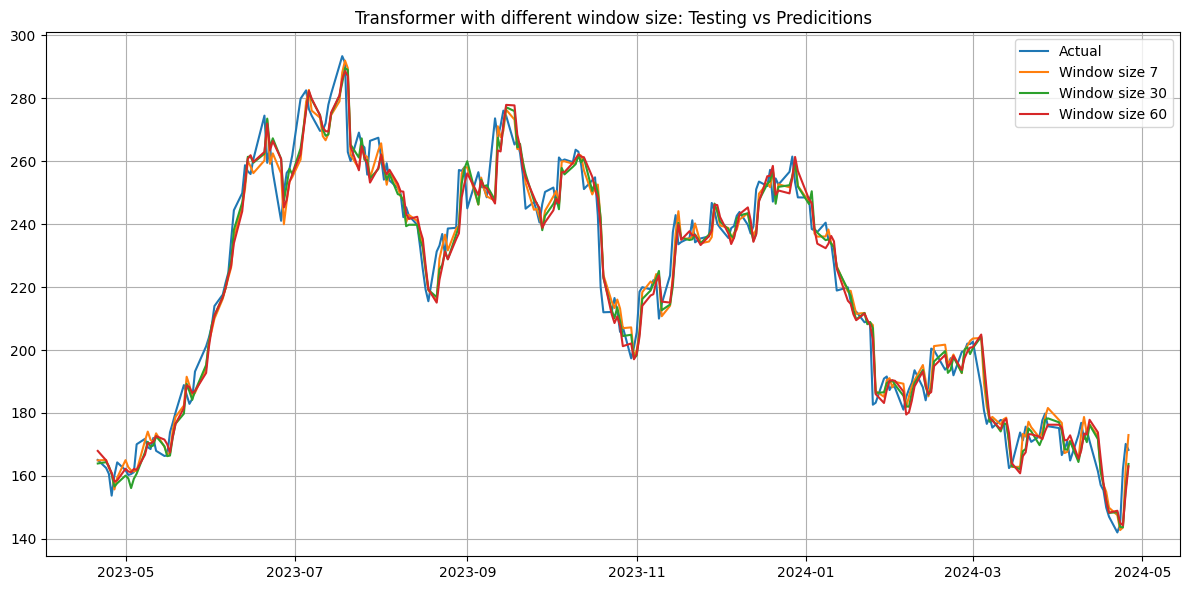

In [46]:
plt.figure(figsize=(12, 6))
#plt.plot(X_['Close'], label = 'Train')
plt.plot(test_results['Actual'], label = 'Actual')
plt.plot(test_results['Window size 7'], label = 'Window size 7')
plt.plot(test_results['Window size 30'], label = 'Window size 30')
plt.plot(test_results['Window size 60'], label = 'Window size 60')
plt.title('Transformer with different window size: Testing vs Predicitions')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()